# Stroke Prediction Training Pipeline

This notebook implements a machine learning pipeline for stroke prediction with the following steps:
1. **Missing Value Handling** - Impute missing BMI values
2. **Preprocessing** - Scale numerical features and encode categorical features
3. **Balancing** - Apply SMOTE to address class imbalance
4. **Feature Selection** - Select most predictive features
5. **Model Training** - Train and evaluate models with cross-validation

**Important**: The original dataset is never modified - all transformations create copies.

## 1. Import Libraries and Load Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [3]:
# Load the dataset (original remains untouched)
df_original = pd.read_csv('data/stroke_data.csv')

# Create a working copy
df = df_original.copy()

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst few rows:")
df.head()

Dataset loaded: 5110 rows, 12 columns

First few rows:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2. Exploratory Data Analysis


In [4]:
# Dataset overview
print("=" * 80)
print("DATASET OVERVIEW")
print("=" * 80)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")

DATASET OVERVIEW

Shape: (5110, 12)

Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']

Data Types:
id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


In [5]:
# Check for missing values
print("=" * 80)
print("MISSING VALUES")
print("=" * 80)
missing = df.isnull().sum()
missing_pct = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing[missing > 0],
    'Percentage': missing_pct[missing > 0]
})
print(missing_df)
print(f"\n⚠️ BMI has {missing['bmi']} missing values ({missing_pct['bmi']:.2f}%)")

MISSING VALUES
     Missing Count  Percentage
bmi            201    3.933464

⚠️ BMI has 201 missing values (3.93%)


In [6]:
# Class distribution - THE CRITICAL IMBALANCE
print("=" * 80)
print("CLASS DISTRIBUTION (TARGET VARIABLE)")
print("=" * 80)
print("\nAbsolute counts:")
print(df['stroke'].value_counts())
print("\nPercentages:")
print(df['stroke'].value_counts(normalize=True) * 100)

imbalance_ratio = df['stroke'].value_counts()[0] / df['stroke'].value_counts()[1]
print(f"\n⚠️ IMBALANCE RATIO: {imbalance_ratio:.2f}:1")
print(f"   - Only {(df['stroke'].sum() / len(df) * 100):.2f}% of cases are strokes!")

CLASS DISTRIBUTION (TARGET VARIABLE)

Absolute counts:
stroke
0    4861
1     249
Name: count, dtype: int64

Percentages:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

⚠️ IMBALANCE RATIO: 19.52:1
   - Only 4.87% of cases are strokes!


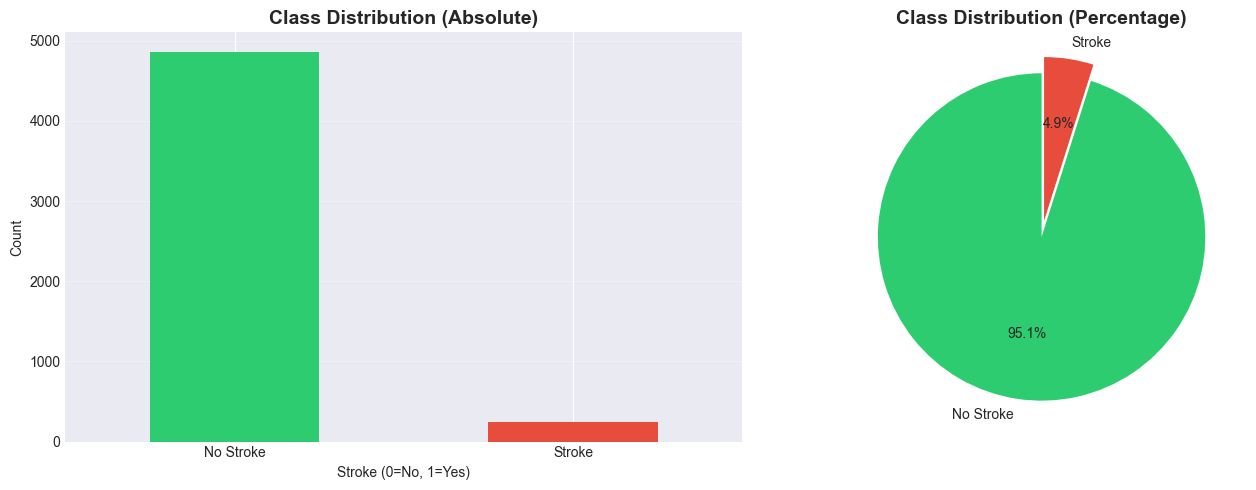

📊 Visualization shows severe class imbalance - SMOTE will be crucial!


In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
df['stroke'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Class Distribution (Absolute)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Stroke (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Stroke', 'Stroke'], rotation=0)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0, 0.1)
df['stroke'].value_counts().plot(
    kind='pie', 
    ax=axes[1], 
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    labels=['No Stroke', 'Stroke'],
    startangle=90
)
axes[1].set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(f"📊 Visualization shows severe class imbalance - SMOTE will be crucial!")

## 3. Data Preparation

### 3.1 Separate Features and Target

In [8]:
# Drop id column (non-predictive)
df_clean = df.drop('id', axis=1)

# Separate features and target
X = df_clean.drop('stroke', axis=1)
y = df_clean['stroke']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {X.columns.tolist()}")

Features shape: (5110, 10)
Target shape: (5110,)

Features: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']


In [9]:
# Identify feature types
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("=" * 80)
print("FEATURE TYPES")
print("=" * 80)
print(f"\nNumerical features ({len(numerical_cols)}):")
for col in numerical_cols:
    print(f"  - {col}")
    
print(f"\nCategorical features ({len(categorical_cols)}):")
for col in categorical_cols:
    unique_vals = X[col].nunique()
    print(f"  - {col} ({unique_vals} unique values)")

FEATURE TYPES

Numerical features (5):
  - age
  - hypertension
  - heart_disease
  - avg_glucose_level
  - bmi

Categorical features (5):
  - gender (3 unique values)
  - ever_married (2 unique values)
  - work_type (5 unique values)
  - Residence_type (2 unique values)
  - smoking_status (4 unique values)


## 4. Step 1: Missing Value Handling

We have 201 missing BMI values. We'll use median imputation (robust to outliers).

BMI ANALYSIS

BMI Statistics (excluding missing):
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64


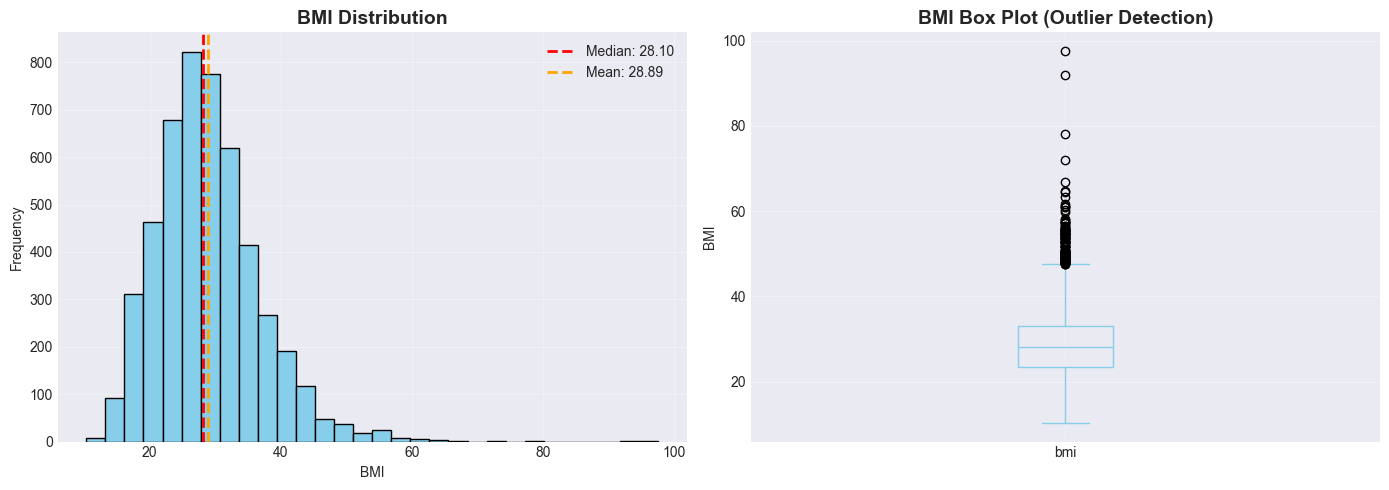


💡 Using MEDIAN (28.10) for imputation (robust to outliers)


In [10]:
# Analyze BMI distribution before imputation
print("=" * 80)
print("BMI ANALYSIS")
print("=" * 80)
print(f"\nBMI Statistics (excluding missing):")
print(X['bmi'].describe())

# Visualize BMI distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
X['bmi'].dropna().hist(bins=30, ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('BMI Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Frequency')
axes[0].axvline(X['bmi'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: {X["bmi"].median():.2f}')
axes[0].axvline(X['bmi'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {X["bmi"].mean():.2f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
X['bmi'].dropna().plot(kind='box', ax=axes[1], color='skyblue')
axes[1].set_title('BMI Box Plot (Outlier Detection)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('BMI')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Using MEDIAN ({X['bmi'].median():.2f}) for imputation (robust to outliers)")

In [11]:
# Create imputer for numerical features (specifically for BMI)
numerical_imputer = SimpleImputer(strategy='median')

# Apply imputation - create a copy to preserve X
X_imputed = X.copy()
X_imputed[numerical_cols] = numerical_imputer.fit_transform(X[numerical_cols])

print("=" * 80)
print("MISSING VALUE IMPUTATION RESULTS")
print("=" * 80)
print(f"\nBefore imputation:")
print(f"  BMI missing: {X['bmi'].isnull().sum()}")
print(f"\nAfter imputation:")
print(f"  BMI missing: {X_imputed['bmi'].isnull().sum()}")
print(f"\n✓ All missing values handled!")
print(f"\n📌 Imputed BMI value: {numerical_imputer.statistics_[numerical_cols.index('bmi')]:.2f}")

MISSING VALUE IMPUTATION RESULTS

Before imputation:
  BMI missing: 201

After imputation:
  BMI missing: 0

✓ All missing values handled!

📌 Imputed BMI value: 28.10


## 5. Step 2: Preprocessing (Scaling & Encoding)

We'll create separate transformers for numerical and categorical features, then combine them.

In [12]:
# Create preprocessing pipeline
print("=" * 80)
print("BUILDING PREPROCESSING PIPELINE")
print("=" * 80)

# Numerical preprocessing: Imputation + Scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

print(f"\n✓ Preprocessing pipeline created:")
print(f"  - Numerical: {len(numerical_cols)} features → Imputation + StandardScaler")
print(f"  - Categorical: {len(categorical_cols)} features → OneHotEncoder")

BUILDING PREPROCESSING PIPELINE

✓ Preprocessing pipeline created:
  - Numerical: 5 features → Imputation + StandardScaler
  - Categorical: 5 features → OneHotEncoder


In [13]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Get feature names after preprocessing
num_feature_names = numerical_cols
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = num_feature_names + list(cat_feature_names)

print("=" * 80)
print("PREPROCESSING RESULTS")
print("=" * 80)
print(f"\nOriginal feature count: {X.shape[1]}")
print(f"After preprocessing: {X_preprocessed.shape[1]}")
print(f"\nFeature expansion breakdown:")
print(f"  - Numerical features: {len(numerical_cols)} (unchanged)")
print(f"  - Categorical features: {len(categorical_cols)} → {len(cat_feature_names)} (after one-hot encoding)")
print(f"\n✓ All features scaled and encoded!")
print(f"\nNew feature names (first 15):")
for i, name in enumerate(all_feature_names[:15], 1):
    print(f"  {i}. {name}")
if len(all_feature_names) > 15:
    print(f"  ... and {len(all_feature_names) - 15} more")

PREPROCESSING RESULTS

Original feature count: 10
After preprocessing: 16

Feature expansion breakdown:
  - Numerical features: 5 (unchanged)
  - Categorical features: 5 → 11 (after one-hot encoding)

✓ All features scaled and encoded!

New feature names (first 15):
  1. age
  2. hypertension
  3. heart_disease
  4. avg_glucose_level
  5. bmi
  6. gender_Male
  7. gender_Other
  8. ever_married_Yes
  9. work_type_Never_worked
  10. work_type_Private
  11. work_type_Self-employed
  12. work_type_children
  13. Residence_type_Urban
  14. smoking_status_formerly smoked
  15. smoking_status_never smoked
  ... and 1 more


In [14]:
# Verify preprocessing: check if features are scaled (mean ≈ 0, std ≈ 1 for numerical)
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names)

print("=" * 80)
print("VERIFICATION: NUMERICAL FEATURES SCALED CORRECTLY")
print("=" * 80)
print("\nNumerical features after scaling (should have mean ≈ 0, std ≈ 1):")
for col in numerical_cols:
    mean = X_preprocessed_df[col].mean()
    std = X_preprocessed_df[col].std()
    print(f"  {col:20s} - Mean: {mean:7.4f}, Std: {std:.4f}")

print("\n✓ Preprocessing verified successfully!")

VERIFICATION: NUMERICAL FEATURES SCALED CORRECTLY

Numerical features after scaling (should have mean ≈ 0, std ≈ 1):
  age                  - Mean:  0.0000, Std: 1.0001
  hypertension         - Mean: -0.0000, Std: 1.0001
  heart_disease        - Mean:  0.0000, Std: 1.0001
  avg_glucose_level    - Mean:  0.0000, Std: 1.0001
  bmi                  - Mean: -0.0000, Std: 1.0001

✓ Preprocessing verified successfully!


## 6. Step 3: Class Balancing with SMOTE

Now we'll apply SMOTE to create synthetic samples of the minority class (stroke=1).

**Important**: SMOTE should only be applied to training data during cross-validation to prevent data leakage!
For demonstration purposes, we'll show the effect here, but in the actual training loop, SMOTE will be applied within each CV fold.

In [15]:
# Split data first (IMPORTANT: SMOTE only on training set)
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class distribution in split
)

print("=" * 80)
print("TRAIN-TEST SPLIT")
print("=" * 80)
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())
print(f"\nClass distribution in test set:")
print(pd.Series(y_test).value_counts())

TRAIN-TEST SPLIT

Training set: 4088 samples
Test set: 1022 samples

Class distribution in training set:
stroke
0    3889
1     199
Name: count, dtype: int64

Class distribution in test set:
stroke
0    972
1     50
Name: count, dtype: int64


## 7. Step 4: Feature Selection with ANOVA F-test

We'll use SelectKBest with ANOVA F-test to identify the most predictive features for stroke prediction.
This is a supervised method that considers the relationship between features and the target variable.

In [52]:
from sklearn.feature_selection import SelectKBest, f_classif

# Configure feature selector
K_FEATURES = 10  # Number of top features to select (we can also try 5, 10, 15, or 'all')

print("=" * 80)
print("FEATURE SELECTION WITH ANOVA F-TEST")
print("=" * 80)
print(f"\nConfiguration:")
print(f"  - Method: SelectKBest with ANOVA F-test (f_classif)")
print(f"  - Number of features to select: {K_FEATURES}")
print(f"  - Current feature count: {X_preprocessed.shape[1]}")

FEATURE SELECTION WITH ANOVA F-TEST

Configuration:
  - Method: SelectKBest with ANOVA F-test (f_classif)
  - Number of features to select: 10
  - Current feature count: 16


In [53]:
# Create and fit the selector on training data
selector = SelectKBest(score_func=f_classif, k=K_FEATURES)

# Fit on training data (before SMOTE to see true relationships)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print("=" * 80)
print("FEATURE SELECTION RESULTS")
print("=" * 80)
print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Selected features: {X_train_selected.shape[1]}")
print(f"Reduction: {X_train.shape[1] - X_train_selected.shape[1]} features removed")

FEATURE SELECTION RESULTS

Original features: 16
Selected features: 10
Reduction: 6 features removed


In [54]:
# Get feature scores and rankings
feature_scores = pd.DataFrame({
    'Feature': all_feature_names,
    'Score': selector.scores_,
    'Selected': selector.get_support()
})

# Sort by score
feature_scores = feature_scores.sort_values('Score', ascending=False)

print("=" * 80)
print("FEATURE IMPORTANCE SCORES")
print("=" * 80)
print("\nTop features (selected):")
print(feature_scores[feature_scores['Selected'] == True].to_string(index=False))

print("\n\nRemoved features:")
print(feature_scores[feature_scores['Selected'] == False].head(10).to_string(index=False))

FEATURE IMPORTANCE SCORES

Top features (selected):
                       Feature      Score  Selected
                           age 281.060925      True
                 heart_disease  81.890083      True
                  hypertension  75.229088      True
             avg_glucose_level  66.350744      True
              ever_married_Yes  39.846185      True
            work_type_children  28.599116      True
       work_type_Self-employed  22.293474      True
smoking_status_formerly smoked  15.129008      True
                           bmi   2.547526      True
          Residence_type_Urban   1.930793      True


Removed features:
                    Feature    Score  Selected
     work_type_Never_worked 0.877896     False
                gender_Male 0.838504     False
      smoking_status_smokes 0.228332     False
          work_type_Private 0.059517     False
               gender_Other 0.051428     False
smoking_status_never smoked 0.027008     False


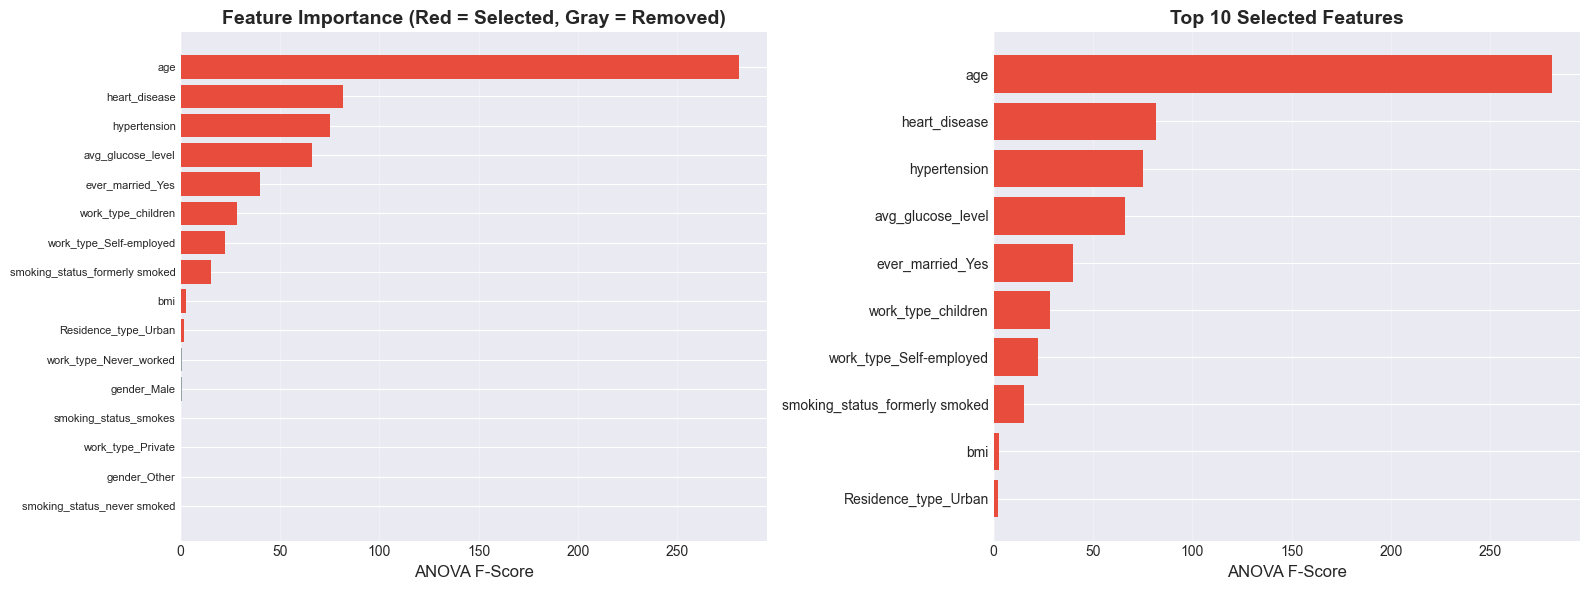

✓ Feature selection complete!


In [55]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of all features
feature_scores_sorted = feature_scores.sort_values('Score', ascending=True)
colors = ['#e74c3c' if selected else '#95a5a6' for selected in feature_scores_sorted['Selected']]

axes[0].barh(range(len(feature_scores_sorted)), feature_scores_sorted['Score'], color=colors)
axes[0].set_yticks(range(len(feature_scores_sorted)))
axes[0].set_yticklabels(feature_scores_sorted['Feature'], fontsize=8)
axes[0].set_xlabel('ANOVA F-Score', fontsize=12)
axes[0].set_title('Feature Importance (Red = Selected, Gray = Removed)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Top K features only
top_k = feature_scores.head(K_FEATURES)
axes[1].barh(range(K_FEATURES), top_k['Score'], color='#e74c3c')
axes[1].set_yticks(range(K_FEATURES))
axes[1].set_yticklabels(top_k['Feature'], fontsize=10)
axes[1].set_xlabel('ANOVA F-Score', fontsize=12)
axes[1].set_title(f'Top {K_FEATURES} Selected Features', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print(f"✓ Feature selection complete!")

In [56]:
# Now apply SMOTE to the selected features for training
print("=" * 80)
print("APPLYING SMOTE TO SELECTED FEATURES")
print("=" * 80)

smote_selected = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)

print("\nBefore SMOTE (selected features):")
print(f"  Training samples: {X_train_selected.shape[0]}")
print(f"  Features: {X_train_selected.shape[1]}")
print(f"  Class 0 (No Stroke): {(y_train == 0).sum()}")
print(f"  Class 1 (Stroke): {(y_train == 1).sum()}")

# Apply SMOTE to selected features
X_train_selected_balanced, y_train_selected_balanced = smote_selected.fit_resample(X_train_selected, y_train)

print("\nAfter SMOTE (selected features):")
print(f"  Training samples: {X_train_selected_balanced.shape[0]}")
print(f"  Features: {X_train_selected_balanced.shape[1]}")
print(f"  Class 0 (No Stroke): {(y_train_selected_balanced == 0).sum()}")
print(f"  Class 1 (Stroke): {(y_train_selected_balanced == 1).sum()}")

print(f"\n✓ Data ready for model training with {K_FEATURES} most predictive features!")
print(f"⚠️ Remember: In production, feature selection and SMOTE should happen within CV folds")

APPLYING SMOTE TO SELECTED FEATURES

Before SMOTE (selected features):
  Training samples: 4088
  Features: 10
  Class 0 (No Stroke): 3888
  Class 1 (Stroke): 200

After SMOTE (selected features):
  Training samples: 7776
  Features: 10
  Class 0 (No Stroke): 3888
  Class 1 (Stroke): 3888

✓ Data ready for model training with 10 most predictive features!
⚠️ Remember: In production, feature selection and SMOTE should happen within CV folds


In [57]:
def apply_feature_selection(X_train, X_val, y_train, k_features=10):
    
    from sklearn.feature_selection import SelectKBest, f_classif

    selector = SelectKBest(score_func=f_classif, k=k_features)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    
    print(f"Feature selection: {X_train.shape[1]} : {X_train_selected.shape[1]} features")
    return X_train_selected, X_val_selected, selector

In [58]:
def apply_smote_balancing(X_train_selected, y_train, random_state=42):
    from imblearn.over_sampling import SMOTE

    smote = SMOTE(sampling_strategy='auto', random_state=random_state, k_neighbors=5)
    X_train_selected_balanced, y_train_selected_balanced = smote_selected.fit_resample(X_train_selected, y_train)
    
    print(f"SMOTE balancing: {len(X_train_selected)} : {len(X_train_selected_balanced)} samples")
    print(f"Class distribution: {y_train_selected_balanced.value_counts().to_dict()}")
    return X_train_selected_balanced, y_train_selected_balanced, smote

In [59]:
import numpy as np
from scipy import sparse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve

skf_temp = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, val_idx = next(iter(skf_temp.split(X_preprocessed, y)))

X_train_temp = X_preprocessed[train_idx]
y_train_temp = y.iloc[train_idx]

X_train_selected_temp, _, _ = apply_feature_selection(X_train_temp, X_train_temp, y_train_temp, k_features=10)
X_train_balanced_temp, y_train_balanced_temp, _ = apply_smote_balancing(X_train_selected_temp, y_train_temp)
is_sparse = sparse.issparse(X)
pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False) if is_sparse else StandardScaler()),
    ('clf', LogisticRegression(random_state=42, max_iter=5000, class_weight='balanced'))
])

param_grid = { 'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'] }

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV( 
    LogisticRegression(
        random_state=42, 
        max_iter=1000, 
        class_weight='balanced'
    ), 
    param_grid, 
    cv=3, 
    scoring='f1' 
)


grid_search.fit(X_train_balanced_temp, y_train_balanced_temp)
best_params = grid_search.best_params_

print(f"Best parameters found: {best_params}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")

print("\nRunning cross-validation with best parameters:")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
roc_curves = []
pr_curves = []
confusion_matrices = []
feature_importance_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_preprocessed, y)):
    print(f"\n--- FOLD {fold + 1}/5 ---")
    
    X_train, X_val = X_preprocessed[train_idx], X_preprocessed[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print(f"Train: {len(X_train)} samples (Stroke: {y_train.sum()}, {y_train.mean()*100:.2f}%)")
    print(f"Val: {len(X_val)} samples (Stroke: {y_val.sum()}, {y_val.mean()*100:.2f}%)")
    
    # Apply feature selection using function
    X_train_selected, X_val_selected, selector = apply_feature_selection(
        X_train, X_val, y_train, k_features=10
    )
    
    selected_indices = selector.get_support(indices=True)
    feature_importance_scores.append({
        'fold': fold + 1,
        'selected_indices': selected_indices,
        'scores': selector.scores_[selector.get_support()]
    })
    
    X_train_balanced, y_train_balanced, smote = apply_smote_balancing(
        X_train_selected, y_train
    )
    
    model = LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced',
        **best_params
    )
    model.fit(X_train_balanced, y_train_balanced)
    
    y_pred = model.predict(X_val_selected)
    y_pred_proba = model.predict_proba(X_val_selected)[:, 1]
    
    metrics = {
        'fold': fold + 1,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_pred_proba)
    }
    
    cv_results.append(metrics)

    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    roc_curves.append({'fpr': fpr, 'tpr': tpr, 'fold': fold + 1})
    pr_curves.append({'precision': precision, 'recall': recall, 'fold': fold + 1})
    
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append({'cm': cm, 'fold': fold + 1})
    
    print(f"Fold {fold + 1} completed - F1: {metrics['f1']:.4f}")

avg_metrics = {}
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
    values = [r[metric] for r in cv_results]
    avg_metrics[metric] = {
        'mean': np.mean(values),
        'std': np.std(values)
    }

for metric, stats in avg_metrics.items():
    print(f"{metric.capitalize():12}: {stats['mean']:.4f} ± {stats['std']:.4f}")

print(f"Best parameters used: {best_params}")

Feature selection: 16 : 10 features
SMOTE balancing: 4088 : 7778 samples
Class distribution: {1: 3889, 0: 3889}
Best parameters found: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 score: 0.7991

Running cross-validation with best parameters:

--- FOLD 1/5 ---
Train: 4088 samples (Stroke: 199, 4.87%)
Val: 1022 samples (Stroke: 50, 4.89%)
Feature selection: 16 : 10 features
SMOTE balancing: 4088 : 7778 samples
Class distribution: {1: 3889, 0: 3889}
Fold 1 completed - F1: 0.2147

--- FOLD 2/5 ---
Train: 4088 samples (Stroke: 199, 4.87%)
Val: 1022 samples (Stroke: 50, 4.89%)
Feature selection: 16 : 10 features
SMOTE balancing: 4088 : 7778 samples
Class distribution: {1: 3889, 0: 3889}
Fold 2 completed - F1: 0.2216

--- FOLD 3/5 ---
Train: 4088 samples (Stroke: 199, 4.87%)
Val: 1022 samples (Stroke: 50, 4.89%)
Feature selection: 16 : 10 features
SMOTE balancing: 4088 : 7778 samples
Class distribution: {1: 3889, 0: 3889}
Fold 3 completed - F1: 0.2384

--- FOLD 4/5 ---
Train: 4088

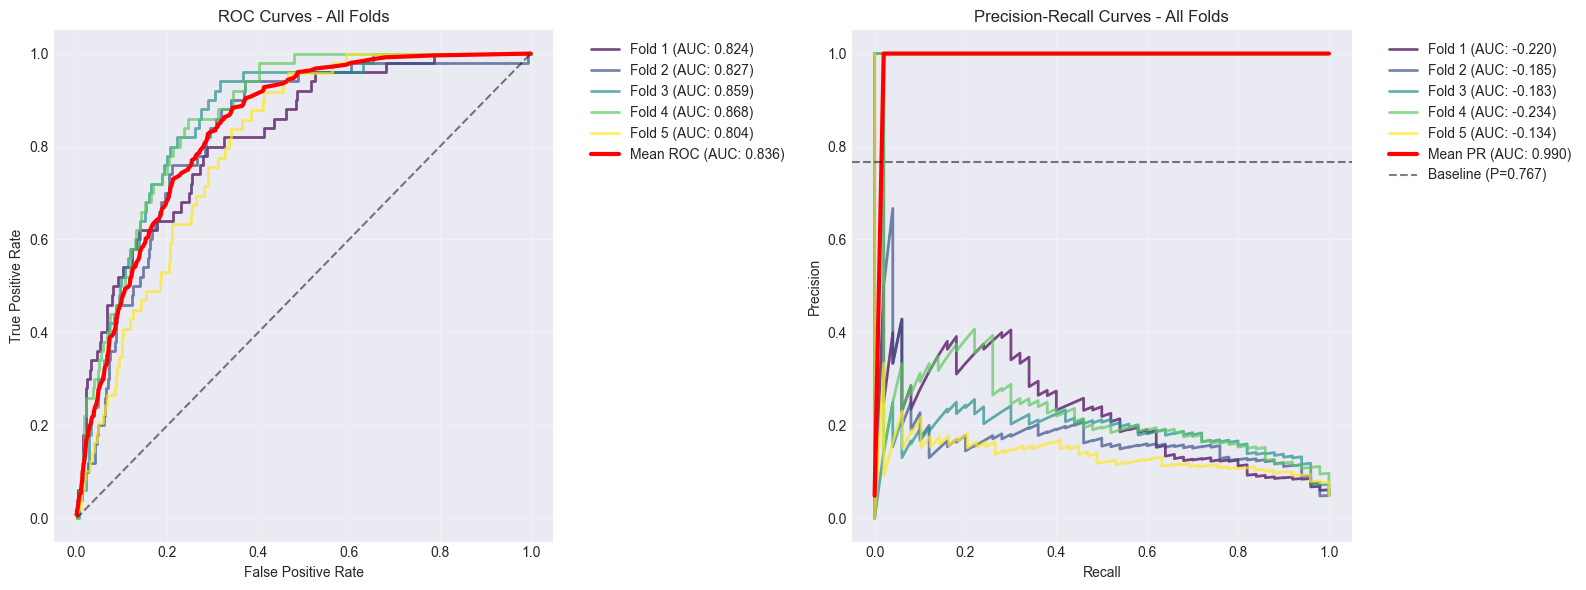

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(roc_curves)))

for i, curve in enumerate(roc_curves):
    ax1.plot(curve['fpr'], curve['tpr'], 
            color=colors[i], alpha=0.7, linewidth=2,
            label=f"Fold {curve['fold']} (AUC: {cv_results[i]['roc_auc']:.3f})")

all_fpr = np.unique(np.concatenate([curve['fpr'] for curve in roc_curves]))
mean_tpr = np.zeros_like(all_fpr)
for curve in roc_curves:
    mean_tpr += np.interp(all_fpr, curve['fpr'], curve['tpr'])
mean_tpr /= len(roc_curves)

mean_auc = np.mean([cv_results[i]['roc_auc'] for i in range(len(cv_results))])
ax1.plot(all_fpr, mean_tpr, color='red', linewidth=3, 
        label=f'Mean ROC (AUC: {mean_auc:.3f})')

ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves - All Folds')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]

for i, curve in enumerate(pr_curves):
    pr_auc = np.trapz(curve['precision'], curve['recall'])
    ax2.plot(curve['recall'], curve['precision'], 
            color=colors[i], alpha=0.7, linewidth=2,
            label=f"Fold {curve['fold']} (AUC: {pr_auc:.3f})")

all_recall = np.unique(np.concatenate([curve['recall'] for curve in pr_curves]))
mean_precision = np.zeros_like(all_recall)
for curve in pr_curves:
    mean_precision += np.interp(all_recall, curve['recall'], curve['precision'])
mean_precision /= len(pr_curves)

mean_pr_auc = np.trapz(mean_precision, all_recall)
ax2.plot(all_recall, mean_precision, color='red', linewidth=3,
        label=f'Mean PR (AUC: {mean_pr_auc:.3f})')

baseline = np.mean([cv_results[i]['recall'] for i in range(len(cv_results))])
ax2.axhline(y=baseline, color='k', linestyle='--', alpha=0.5, 
            label=f'Baseline (P={baseline:.3f})')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curves - All Folds')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

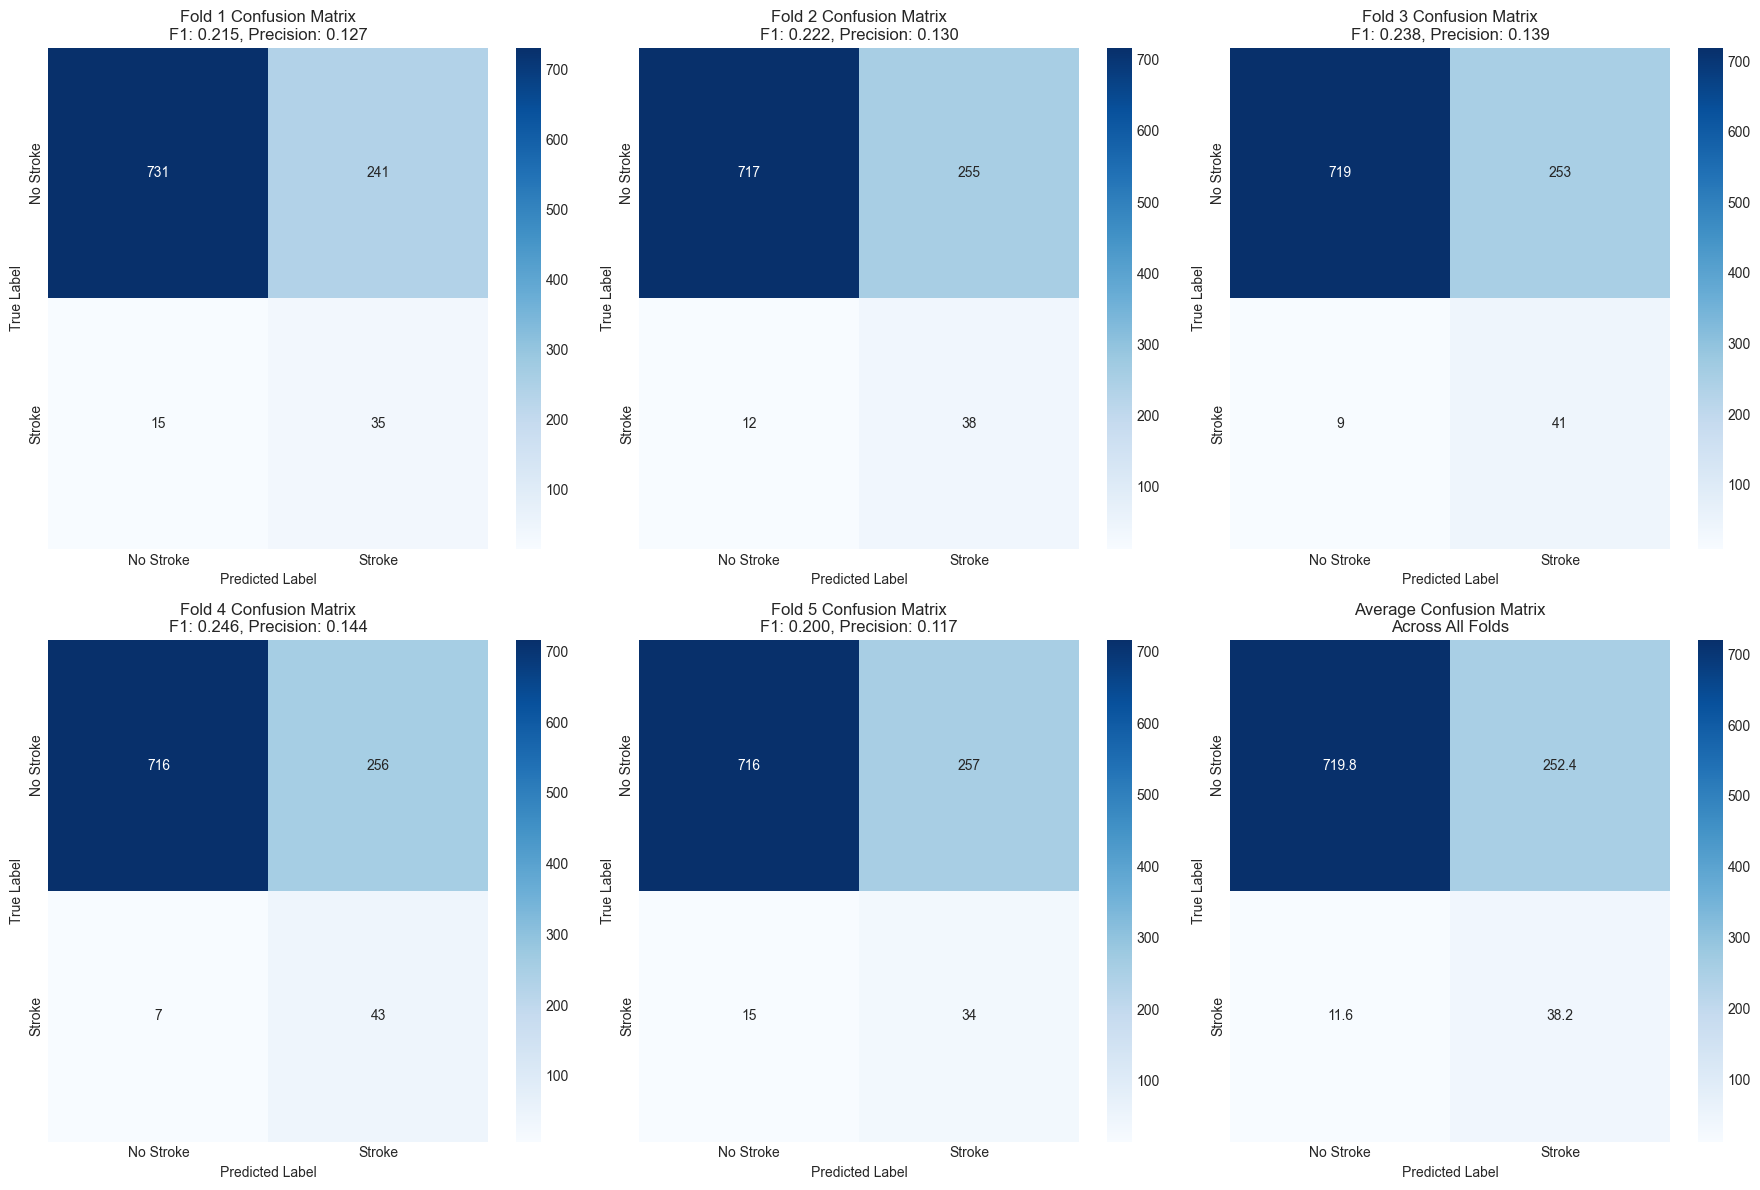

In [61]:

n_folds = len(confusion_matrices)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, cm_data in enumerate(confusion_matrices):
    if i < 5:
        cm = cm_data['cm']
        ax = axes[i]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['No Stroke', 'Stroke'],
                    yticklabels=['No Stroke', 'Stroke'])
        ax.set_title(f'Fold {cm_data["fold"]} Confusion Matrix\n'
                    f'F1: {cv_results[i]["f1"]:.3f}, '
                    f'Precision: {cv_results[i]["precision"]:.3f}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')

if len(confusion_matrices) > 0:
    avg_cm = np.mean([cm_data['cm'] for cm_data in confusion_matrices], axis=0)
    ax = axes[5]
    
    sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='Blues', ax=ax,
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    ax.set_title('Average Confusion Matrix\nAcross All Folds')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

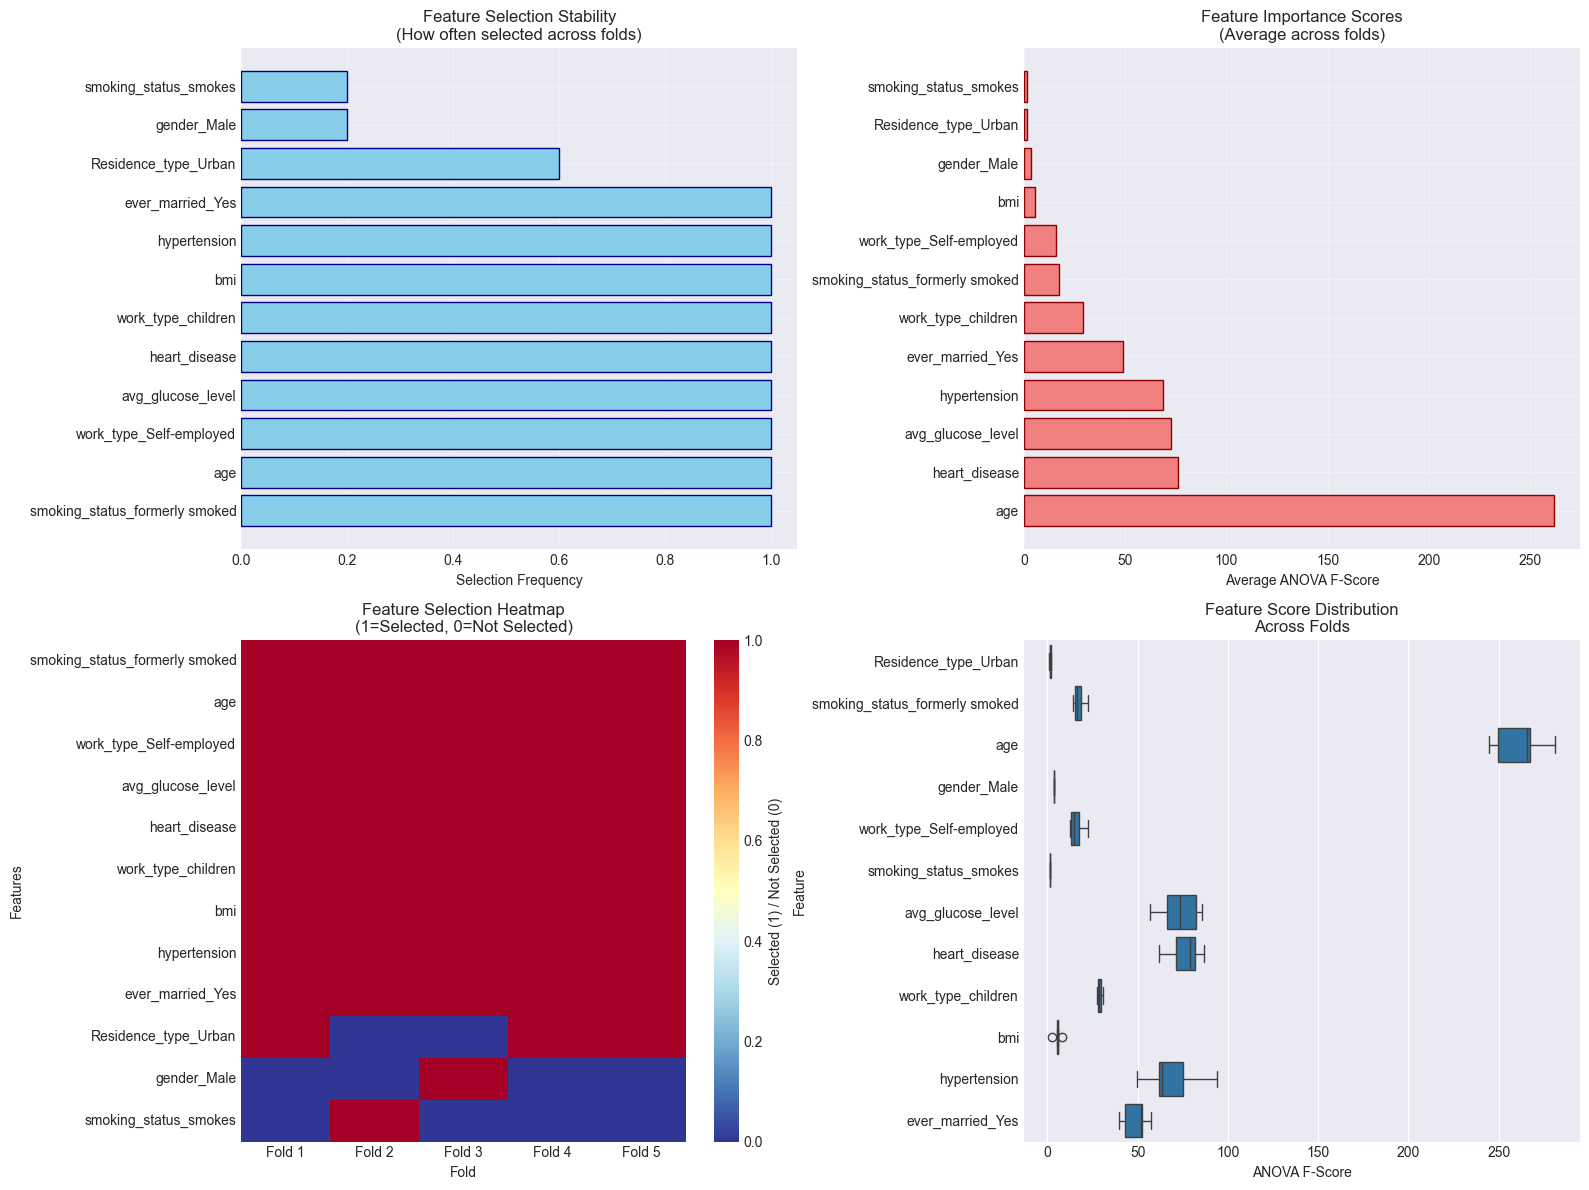


Feature Selection Summary:
smoking_status_formerly smoked: Selected 100.0% of folds, Avg Score:    17.21
age                      : Selected 100.0% of folds, Avg Score:   261.68
work_type_Self-employed  : Selected 100.0% of folds, Avg Score:    16.04
avg_glucose_level        : Selected 100.0% of folds, Avg Score:    72.81
heart_disease            : Selected 100.0% of folds, Avg Score:    76.04
work_type_children       : Selected 100.0% of folds, Avg Score:    28.96
bmi                      : Selected 100.0% of folds, Avg Score:     5.48
hypertension             : Selected 100.0% of folds, Avg Score:    68.81
ever_married_Yes         : Selected 100.0% of folds, Avg Score:    48.78
Residence_type_Urban     : Selected  60.0% of folds, Avg Score:     1.52
gender_Male              : Selected  20.0% of folds, Avg Score:     3.48
smoking_status_smokes    : Selected  20.0% of folds, Avg Score:     1.52


In [62]:
all_selected_features = set()
for fold_data in feature_importance_scores:
    selected_indices = fold_data['selected_indices']
    for idx in selected_indices:
        if idx < len(all_feature_names):
            all_selected_features.add(all_feature_names[idx])

feature_stability = {}
feature_scores_across_folds = {}

for feature in all_selected_features:
    feature_idx = all_feature_names.index(feature)
    stability_count = 0
    scores = []
    
    for fold_data in feature_importance_scores:
        if feature_idx in fold_data['selected_indices']:
            stability_count += 1
            selected_scores = fold_data['scores']
            selected_indices = fold_data['selected_indices']
            if feature_idx in selected_indices:
                score_idx = list(selected_indices).index(feature_idx)
                scores.append(selected_scores[score_idx])
    
    feature_stability[feature] = stability_count / len(feature_importance_scores)
    feature_scores_across_folds[feature] = scores

sorted_features = sorted(feature_stability.items(), key=lambda x: x[1], reverse=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

features, stability = zip(*sorted_features)
axes[0, 0].barh(range(len(features)), stability, color='skyblue', edgecolor='navy')
axes[0, 0].set_yticks(range(len(features)))
axes[0, 0].set_yticklabels(features, fontsize=10)
axes[0, 0].set_xlabel('Selection Frequency')
axes[0, 0].set_title('Feature Selection Stability\n(How often selected across folds)')
axes[0, 0].grid(True, alpha=0.3)

feature_avg_scores = {}
for feature, scores in feature_scores_across_folds.items():
    if scores:
        feature_avg_scores[feature] = np.mean(scores)

sorted_by_score = sorted(feature_avg_scores.items(), key=lambda x: x[1], reverse=True)
features_score, scores_avg = zip(*sorted_by_score)

axes[0, 1].barh(range(len(features_score)), scores_avg, color='lightcoral', edgecolor='darkred')
axes[0, 1].set_yticks(range(len(features_score)))
axes[0, 1].set_yticklabels(features_score, fontsize=10)
axes[0, 1].set_xlabel('Average ANOVA F-Score')
axes[0, 1].set_title('Feature Importance Scores\n(Average across folds)')
axes[0, 1].grid(True, alpha=0.3)

fold_names = [f"Fold {i+1}" for i in range(len(feature_importance_scores))]
heatmap_data = []

for feature in features:
    row = []
    for fold_data in feature_importance_scores:
        feature_idx = all_feature_names.index(feature)
        if feature_idx in fold_data['selected_indices']:
            row.append(1)
        else:
            row.append(0)
    heatmap_data.append(row)

sns.heatmap(heatmap_data, 
            xticklabels=fold_names,
            yticklabels=features,
            cmap='RdYlBu_r', 
            ax=axes[1, 0],
            cbar_kws={'label': 'Selected (1) / Not Selected (0)'})
axes[1, 0].set_title('Feature Selection Heatmap\n(1=Selected, 0=Not Selected)')
axes[1, 0].set_xlabel('Fold')
axes[1, 0].set_ylabel('Features')

all_scores = []
all_feature_names_plot = []
for feature, scores in feature_scores_across_folds.items():
    all_scores.extend(scores)
    all_feature_names_plot.extend([feature] * len(scores))

if all_scores:
    score_df = pd.DataFrame({'Feature': all_feature_names_plot, 'Score': all_scores})
    sns.boxplot(data=score_df, x='Score', y='Feature', ax=axes[1, 1])
    axes[1, 1].set_title('Feature Score Distribution\nAcross Folds')
    axes[1, 1].set_xlabel('ANOVA F-Score')

plt.tight_layout()
plt.show()

print("\nFeature Selection Summary:")
for feature, stability in sorted_features:
    avg_score = feature_avg_scores.get(feature, 0)
    print(f"{feature:25s}: Selected {stability*100:5.1f}% of folds, Avg Score: {avg_score:8.2f}")